In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class NadarayaWatson:
    def __init__(self, kernel_func, bandwidth):
        self.kernel_func = kernel_func
        self.bandwidth = bandwidth
        self.X = None
        self.Y = None

    def fit(self, X, Y):
        self.X = np.array(X).reshape(-1)
        self.Y = np.array(Y).reshape(-1)
        return self
    
    def predict(self, X_new):
        X_new = np.array(X_new).reshape(-1)
        predictions = []
        for x in X_new:
            weights = self.kernel_func((x - self.X) / self.bandwidth)
            # Add small epsilon to avoid division by zero
            denominator = np.sum(weights) + 1e-10
            prediction = np.sum(weights * self.Y) / denominator
            predictions.append(prediction)
        return np.array(predictions)

In [3]:
def gaussian_kernel(x):
    return np.exp(-0.5 * (x**2)) / np.sqrt(2*np.pi)

def epanechnikov_kernel(x):
    return 0.75*(1-x**2)*(np.abs(x)<=1)

In [4]:
def risk(Y_true, Y_pred):
    return np.mean((Y_true - Y_pred)**2)

In [5]:
def k_fold_cross_validation(X, Y, kernel_func, bandwidth, k=5):
    n = len(X)
    # Ensure data is properly shuffled while maintaining correspondence
    indices = np.arange(n)
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    
    fold_size = n // k
    risks = []
    
    for i in range(k):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size if i < k-1 else n
        
        # Create validation fold
        val_indices = np.arange(start_idx, end_idx)
        train_indices = np.concatenate([np.arange(0, start_idx), np.arange(end_idx, n)])
        
        X_train, Y_train = X[train_indices], Y[train_indices]
        X_val, Y_val = X[val_indices], Y[val_indices]
        
        # Fit model and compute risk
        model = NadarayaWatson(kernel_func, bandwidth)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_val)
        current_risk = risk(Y_val, Y_pred)
        risks.append(current_risk)
    
    return np.mean(risks)

In [6]:

def optimal_bandwidth(X, Y, kernel_func, bandwidths):
    # Use fewer bandwidths for a smoother curve
    risks = []
    for h in bandwidths:
        try:
            current_risk = k_fold_cross_validation(X, Y, kernel_func, h)
            risks.append(current_risk)
        except Exception as e:
            print(f"Error at bandwidth {h}: {e}")
            risks.append(np.inf)
    
    risks = np.array(risks)
    # Find optimal bandwidth avoiding extreme values
    valid_risks = risks[np.isfinite(risks)]
    if len(valid_risks) > 0:
        optimal = bandwidths[np.argmin(risks)]
    else:
        optimal = np.median(bandwidths)
    
    return optimal, np.array(risks)


In [7]:
df = pd.read_csv('Forensic_glass_data.csv')
X = df['Al'].values
Y = df['RI'].values

bandwidths = np.linspace(1e-1, 1, 100)

In [8]:
np.random.seed(42)
indices = np.random.permutation(len(X))
train_size = int(0.75 * len(X))
X_train, Y_train = X[indices[:train_size]], Y[indices[:train_size]]
X_dev, Y_dev = X[indices[train_size:]], Y[indices[train_size:]]

0.18018018018018017


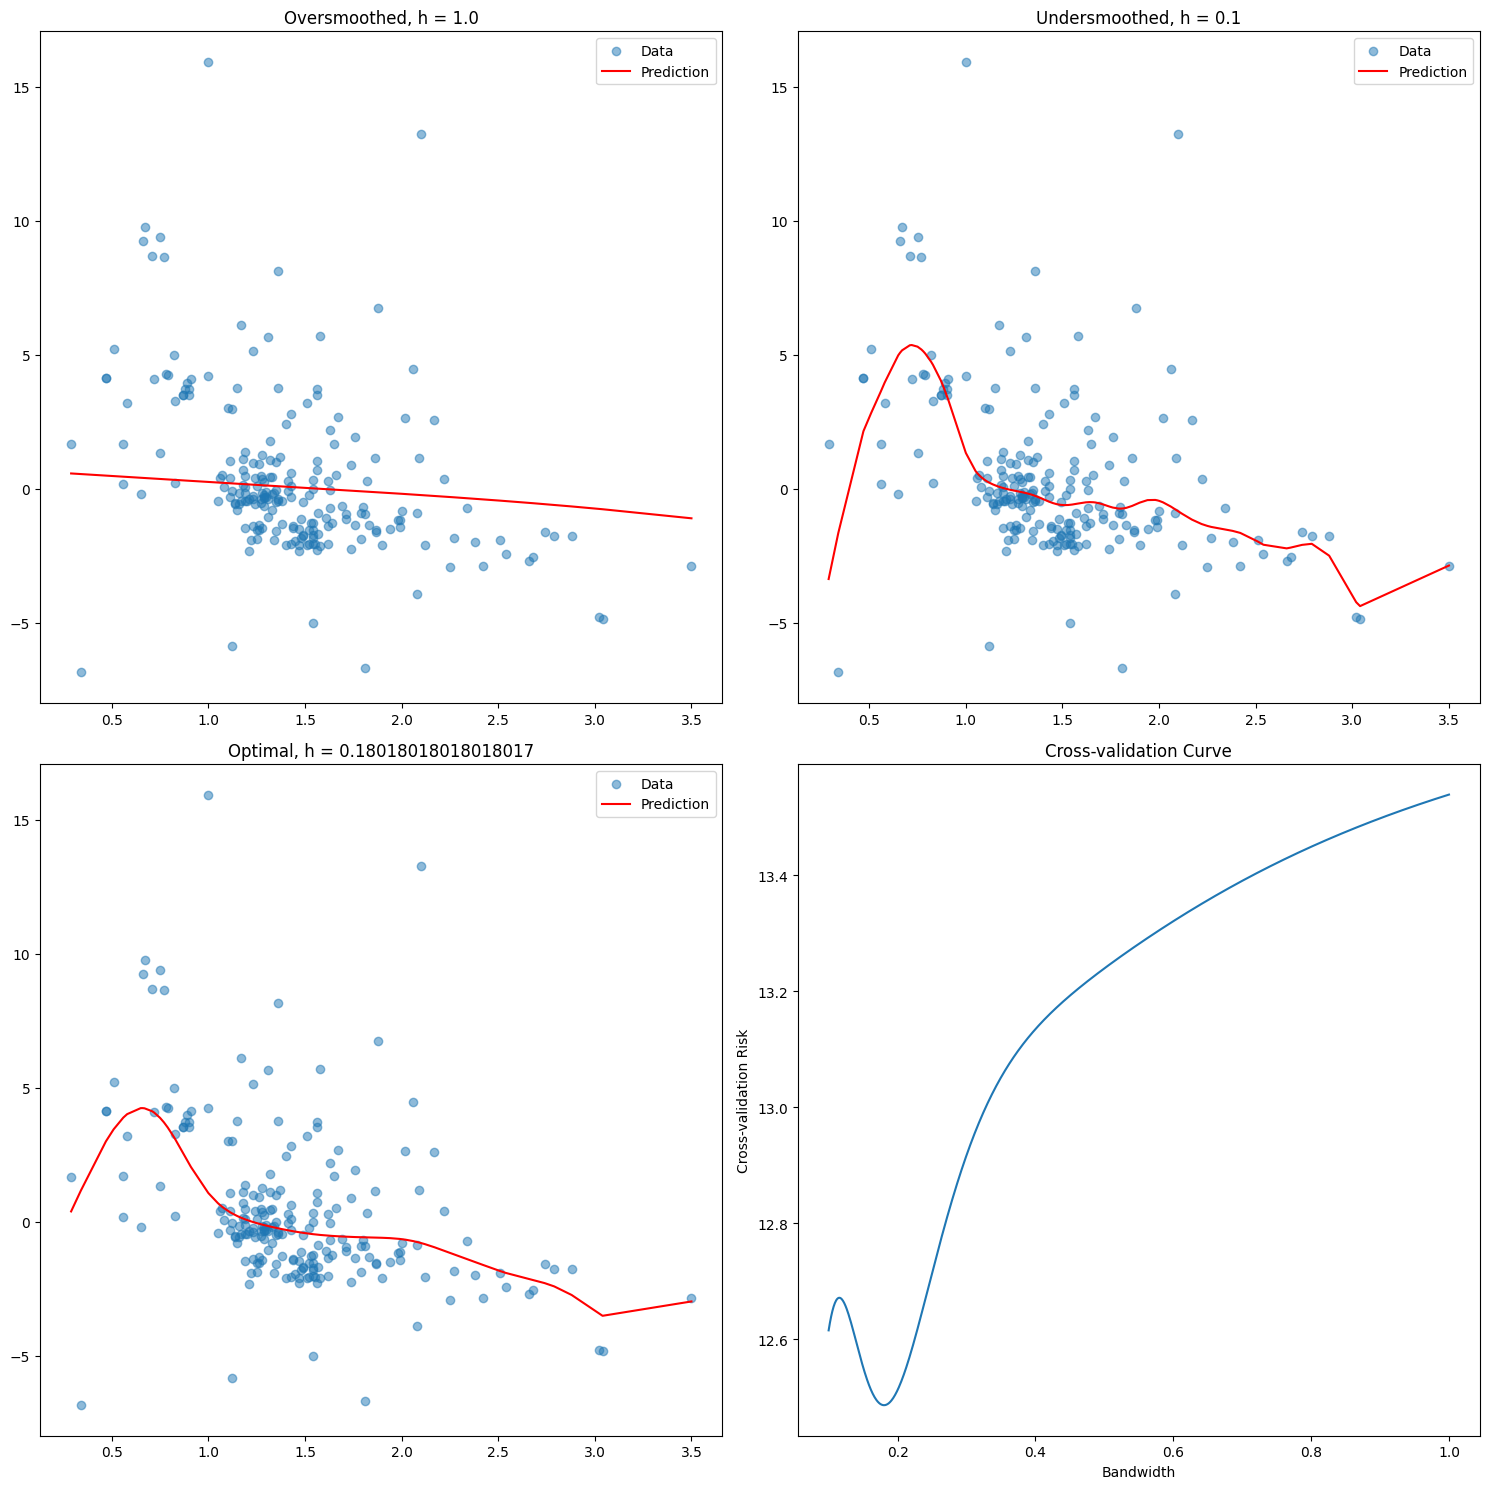

In [17]:
gaussian_optimal_h, gaussian_risks = optimal_bandwidth(X_dev, Y_dev, gaussian_kernel, bandwidths)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
row, col = 0,0
model = NadarayaWatson(gaussian_kernel, bandwidths[-1])
model.fit(X_train, Y_train)

X_sorted = np.sort(X)
Y_pred = model.predict(X_sorted)

axes[row, col].scatter(X, Y, alpha=0.5, label='Data')
axes[row, col].plot(X_sorted, Y_pred, 'r-', label='Prediction')
axes[row, col].set_title(f"Oversmoothed, h = {bandwidths[-1]}")
axes[row, col].legend()

row, col = 0,1
model = NadarayaWatson(gaussian_kernel, bandwidths[0])
model.fit(X_train, Y_train)

X_sorted = np.sort(X)
Y_pred = model.predict(X_sorted)

axes[row, col].scatter(X, Y, alpha=0.5, label='Data')
axes[row, col].plot(X_sorted, Y_pred, 'r-', label='Prediction')
axes[row, col].set_title(f"Undersmoothed, h = {bandwidths[0]}")
axes[row, col].legend()

row, col = 1,0
model = NadarayaWatson(gaussian_kernel, gaussian_optimal_h)
model.fit(X_train, Y_train)

X_sorted = np.sort(X)
Y_pred = model.predict(X_sorted)

axes[row, col].scatter(X, Y, alpha=0.5, label='Data')
axes[row, col].plot(X_sorted, Y_pred, 'r-', label='Prediction')
axes[row, col].set_title(f"Optimal, h = {gaussian_optimal_h}")
axes[row, col].legend()

axes[1, 1].plot(bandwidths, gaussian_risks)
# axes[1, 1].set_xscale('log')
axes[1, 1].set_xlabel('Bandwidth')
axes[1, 1].set_ylabel('Cross-validation Risk')
axes[1, 1].set_title('Cross-validation Curve')
plt.tight_layout()
print(gaussian_optimal_h)
plt.savefig('../images/4/gaussian_kernel_regression.png')


0.16363636363636364


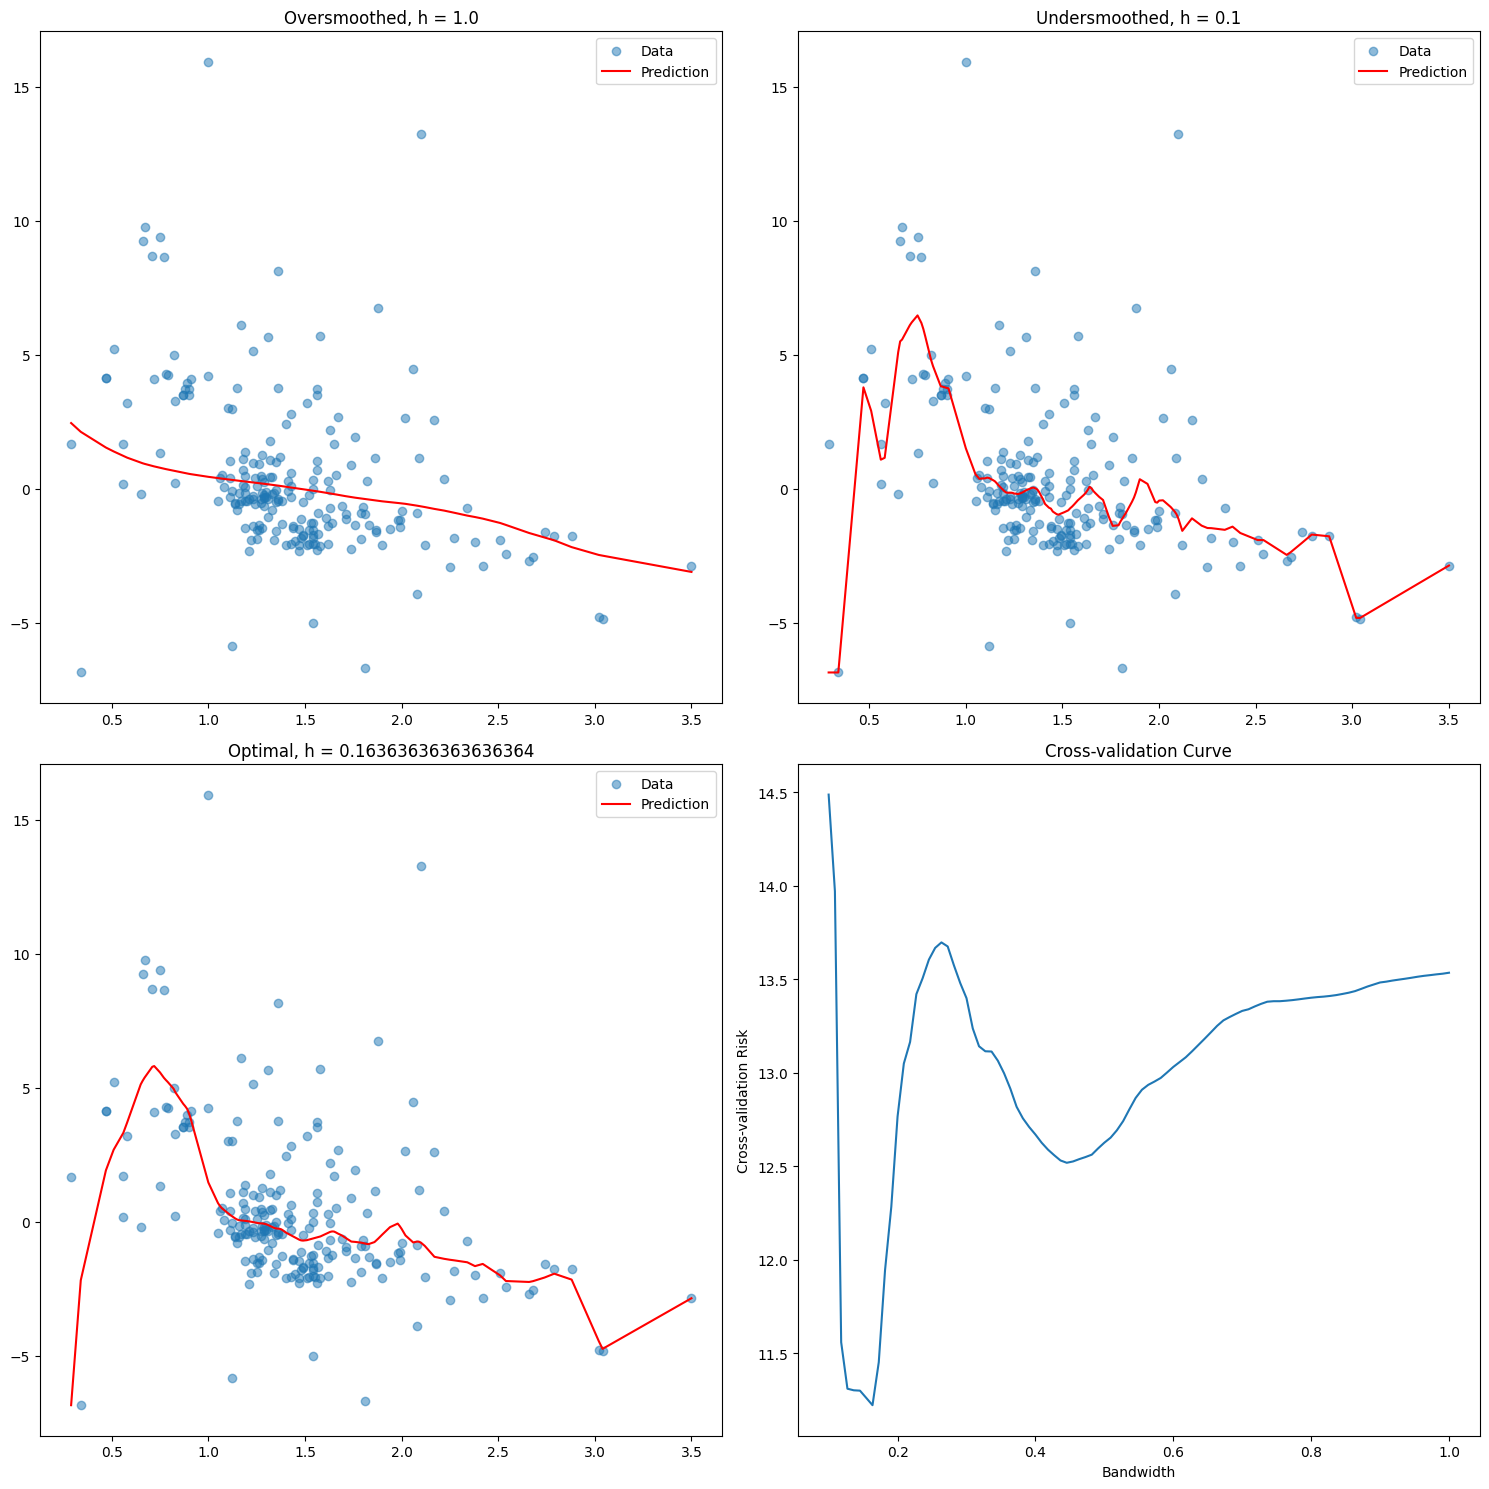

In [18]:
bandwidths = np.linspace(1e-1, 1, 100)
epanechnikov_optimal_h, epanechnikov_risks = optimal_bandwidth(X_dev, Y_dev, epanechnikov_kernel, bandwidths)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
row, col = 0,0
model = NadarayaWatson(epanechnikov_kernel, bandwidths[-1])
model.fit(X_train, Y_train)

X_sorted = np.sort(X)
Y_pred = model.predict(X_sorted)

axes[row, col].scatter(X, Y, alpha=0.5, label='Data')
axes[row, col].plot(X_sorted, Y_pred, 'r-', label='Prediction')
axes[row, col].set_title(f"Oversmoothed, h = {bandwidths[-1]}")
axes[row, col].legend()

row, col = 0,1
model = NadarayaWatson(epanechnikov_kernel, bandwidths[0])
model.fit(X_train, Y_train)

X_sorted = np.sort(X)
Y_pred = model.predict(X_sorted)

axes[row, col].scatter(X, Y, alpha=0.5, label='Data')
axes[row, col].plot(X_sorted, Y_pred, 'r-', label='Prediction')
axes[row, col].set_title(f"Undersmoothed, h = {bandwidths[0]}")
axes[row, col].legend()

row, col = 1,0
model = NadarayaWatson(epanechnikov_kernel, epanechnikov_optimal_h)
model.fit(X_train, Y_train)

X_sorted = np.sort(X)
Y_pred = model.predict(X_sorted)

axes[row, col].scatter(X, Y, alpha=0.5, label='Data')
axes[row, col].plot(X_sorted, Y_pred, 'r-', label='Prediction')
axes[row, col].set_title(f"Optimal, h = {epanechnikov_optimal_h}")
axes[row, col].legend()

axes[1, 1].plot(bandwidths, epanechnikov_risks)
axes[1, 1].set_xlabel('Bandwidth')
axes[1, 1].set_ylabel('Cross-validation Risk')
axes[1, 1].set_title('Cross-validation Curve')
plt.tight_layout()
print(epanechnikov_optimal_h)
plt.savefig('../images/4/epanechnikov_kernel_regression.png')